In [1]:
%load_ext autoreload
%autoreload 2

import torch 
import os
import glob
from matplotlib import pyplot as plt

import matplotlib.animation as animation
import os
import torch
import numpy as np
import pandas as pd
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')


from distributions import ZeroInflatedDist, QuantizedNormal
from torch_models import MixtureOfTruncNormModel, SpatialWaves
from torch_training import train_epoch
from torch_perturb.torch_pert_topk import PerturbedTopK
import time
from torch_training import train_epoch_largesynth
from torch_models import torch_bpr_uncurried, deterministic_bpr

In [2]:
deaths = pd.read_csv('deaths1.csv')
pop = pd.read_csv('pop1.csv')
data_shape = (25, 56)

In [3]:
# turn the death column into a time-by-geoid array
deaths_TS = deaths.pivot(index='time', columns='geoid', values='death').values
pop_S = pop['pop'].values

T, S = deaths_TS.shape
# create latitude and longitude arrays corresponding to the row and column index of the geoids when reshaped into data_shape
lat = np.linspace(25, 50, data_shape[0])
lon = np.linspace(-125, -65, data_shape[1])
lat_S, lon_S = np.meshgrid(lon, lat)
lat_S = lat_S.flatten()
lon_S = lon_S.flatten()
# create column of time values
time_T = np.arange(deaths_TS.shape[0])
time_T = torch.tensor(time_T, dtype=torch.float32)
lat_S = torch.tensor(lat_S, dtype=torch.float32)
lon_S = torch.tensor(lon_S, dtype=torch.float32)
pop_S = torch.tensor(pop_S, dtype=torch.float32)
S = pop_S.shape[0]
T = time_T.shape[0]


model  = SpatialWaves(num_waves=1,low=0, high=1000000)

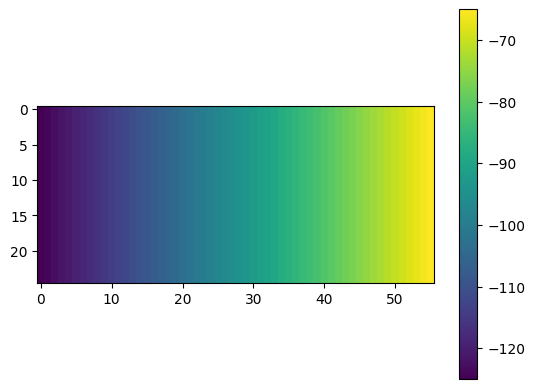

In [4]:
plt.imshow(lat_S.view(data_shape))
plt.colorbar()

In [5]:
lat_S.view(data_shape)[:,52]

tensor([-68.2727, -68.2727, -68.2727, -68.2727, -68.2727, -68.2727, -68.2727,
        -68.2727, -68.2727, -68.2727, -68.2727, -68.2727, -68.2727, -68.2727,
        -68.2727, -68.2727, -68.2727, -68.2727, -68.2727, -68.2727, -68.2727,
        -68.2727, -68.2727, -68.2727, -68.2727])

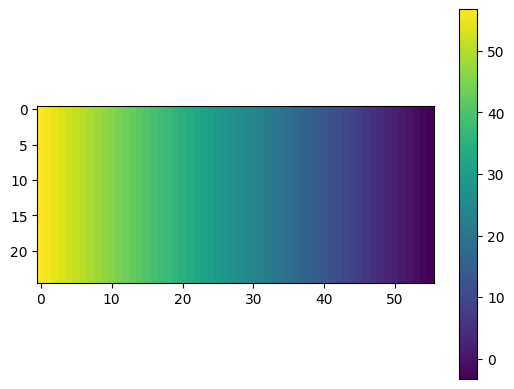

In [45]:
arrival_speed=torch.tensor([1])

lon_coeff = torch.tensor([0.0,])
lat_coeff = torch.tensor([-1.0])
arrival_intercept = torch.tensor([lat_S.view(data_shape)[0,52]]) 
mag=0.005
width=4
softinv_mags = torch.tensor([mag]) + torch.log(-torch.expm1(torch.tensor(-np.array([mag]))))
softinv_widths = torch.tensor([width]) + torch.log(-torch.expm1(torch.tensor(-np.array([width]))))
plt.imshow((arrival_intercept + lat_coeff*lat_S + lon_coeff*lon_S).view(data_shape))
plt.colorbar()
model.update_params(torch.cat([arrival_speed, arrival_intercept, lat_coeff, lon_coeff, softinv_mags, softinv_widths]))

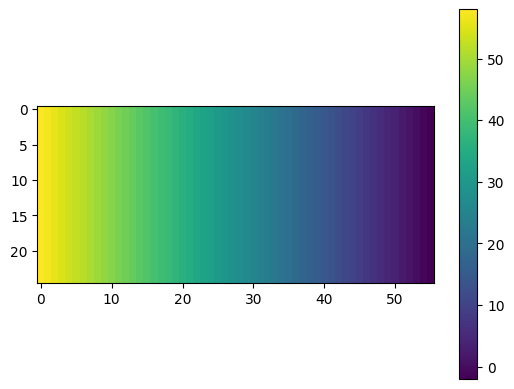

In [55]:
arrival_speed=torch.tensor([1])

lon_coeff = torch.tensor([0.0,])
lat_coeff = torch.tensor([-1])
arrival_intercept = torch.tensor([-67]) 
mag=0.005
width=40
softinv_mags = torch.tensor([mag]) + torch.log(-torch.expm1(torch.tensor(-np.array([mag]))))
softinv_widths = torch.tensor([width]) + torch.log(-torch.expm1(torch.tensor(-np.array([width]))))
plt.imshow((arrival_intercept + lat_coeff*lat_S + lon_coeff*lon_S).view(data_shape))
plt.colorbar()
model.update_params(torch.cat([arrival_speed, arrival_intercept, lat_coeff, lon_coeff, softinv_mags, softinv_widths]))

In [56]:
M_score_func = 20
M_action = 20

In [57]:
arrival_speed

tensor([1])

In [58]:
dist = model(time_T,pop_S, lat_S, lon_S)
y_sample_TMS = dist.sample((M_score_func, )).permute(1, 0, 2)

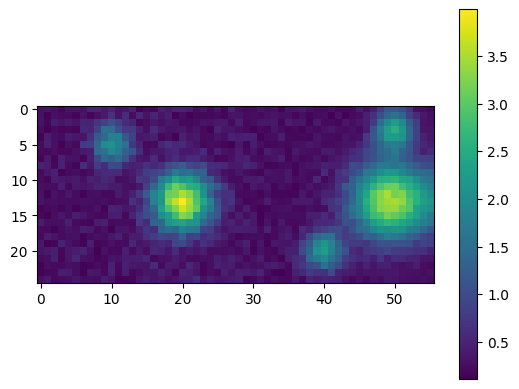

In [59]:
plt.imshow(y_sample_TMS.mean(1)[40,:].view(data_shape))
plt.colorbar()

In [60]:
step_size = 0.001
K=50
optimizer = torch.optim.Adam(model.parameters(), lr=step_size)
perturbed_top_K_func = PerturbedTopK(k=K, sigma=0.0001, num_samples=20)
losses, bprs, nlls, times = [], [], [], []

In [61]:
start = time.time()
bpr, nll, model = calc_nll_bpr(model, K,
                                    M_score_func, time_T,pop_S,
                                    lat_S, lon_S, deaths_TS, 
                                    perturbed_top_K_func, )
end = time.time()
elapsed = end - start


det bpr: 0.4434533332632017
Pert bpr: 0.4437261807319789
nll: 13.594543638407432


In [51]:
def calc_nll_bpr(model, K, M_score_func,
                 time_T,pop_S, lat_S, lon_S, train_y_TS,
                 perturbed_top_K_func):

    dist = model(time_T,pop_S, lat_S, lon_S)
    
    y_sample_TMS = dist.sample((M_score_func,)).permute(1, 0, 2)
    y_sample_action_TMS = y_sample_TMS

    ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
    ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
    ratio_rating_TS.requires_grad_(True)
 

    positive_bpr_T = torch_bpr_uncurried(ratio_rating_TS, torch.tensor(train_y_TS), K=K, perturbed_top_K_func=perturbed_top_K_func)

    
    nll = torch.mean(-dist.log_prob( torch.tensor(train_y_TS)))


    deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(train_y_TS), K=K)
    det_bpr =torch.mean(deterministic_bpr_T)

    print(f'det bpr: {det_bpr}')
    print(f'Pert bpr: {torch.mean(positive_bpr_T)}')
    print(f'nll: {nll}')
    sys.stdout.flush()

    return  det_bpr.detach(), nll.detach(), model

In [43]:
dist = model(time_T,pop_S, lat_S, lon_S)

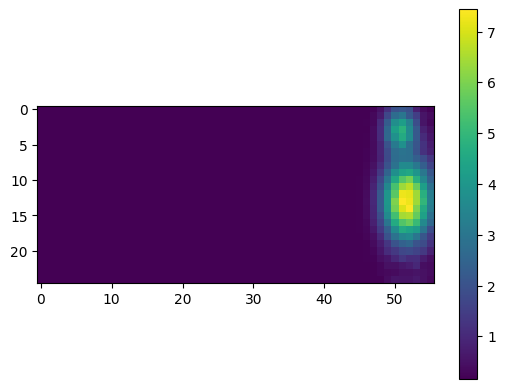

In [44]:
plt.imshow(dist.mean[0,:].view(data_shape).detach())
plt.colorbar()

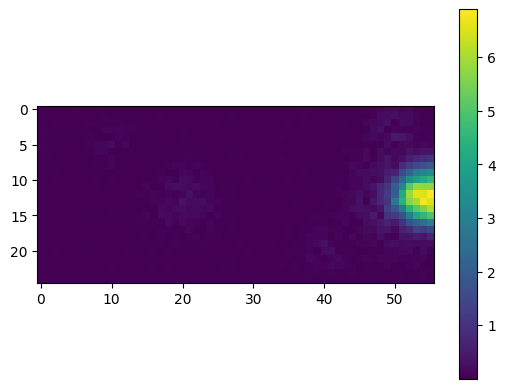

In [31]:
plt.imshow(torch.tensor(deaths_TS[0,:]).view(data_shape))
plt.colorbar()

In [28]:
deaths_TS[0,:]

array([0.00860514, 0.01307148, 0.00606655, ..., 0.0526962 , 0.05592019,
       0.02631266])